# Rotor plane analysis

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import postproamrwindsample_xarray as ppsamplexr
import pickle
import pandas as pd

# Make all plots inline 
%matplotlib inline

In [2]:
extractvar = lambda xrds, var, i : xrds[var][i,:].data.reshape(tuple(xrds.attrs['ijk_dims'][::-1]))

def loadPickle(picklefname):
    pfile = open(picklefname, 'rb')
    db   = pickle.load(pfile)
    x    = db['x']
    y    = db['y']
    z    = db['z']
    vx   = db['vx']
    vy   = db['vy']
    vz   = db['vz']
    time = db['time']
    pfile.close()
    return x, y, z, vx, vy, vz, time

def avgfield(v, mintime, maxtime):
    avgv = None
    iavg = 0
    for itime, vfield in v.items():
        if (mintime<=itime) and (itime<=maxtime):
            iavg += 1
            if avgv is None:
                avgv = vfield
            else:
                avgv += vfield
    #print(iavg)
    return avgv/float(iavg)

def avgdb(db, var, avglims):
    avgd = None
    avgcount = 0
    for t, g in db[var].items():
        if (avglims[0]<=t) and (t<=avglims[1]):
            if avgd is None:
                avgd = g+ 0.0
            else: 
                avgd += g
            avgcount += 1
    return avgd/avgcount

def appendavg(db, varlist, avglims, suffix='_avg'):
    for v in varlist:
        db[v+suffix] = avgdb(db, v, avglims)
    return

def makecbarax(ax, c, fontsize, size='5%'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize)

def setfigtextsize(ax, fsize):
    fontelem = ([ax.title, ax.xaxis.label, ax.yaxis.label, 
                 ax.yaxis.get_offset_text(), ax.xaxis.get_offset_text()] + 
                ax.get_xticklabels() + ax.get_yticklabels() )
    for item in fontelem:
        item.set_fontsize(fsize)

In [3]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

In [4]:
summitcsv    = '../UnstableABL_farmrun_turbines.csv'
#wturbdir     = '/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun2_wturbs/post_processing/'
#noturbdir    = '/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun2_noturbs/post_processing/'
wturbdir     = '/lustre/orion/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun1_wturbs/post_processing'
noturbdir    = '/lustre/orion/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun1_noturbs/post_processing'
ncfile       = 'KProtor_64500.nc'
pkldir       = 'means/KPturbssw.2/'
turbname     = '%s_sw_mean_%s.pkl'
tavg1 = 300
tavg2 = 999

iters  = np.arange(360, 1000, 60)
varnames = ['velocity_meanx', 'velocity_meany', 'velocity_meanz']  # variables to extract

In [5]:
savefigs = True
figdir   = 'JRSE_figs'

In [6]:
allturblist = getturbnames(getTurbSubset(summitcsv, '-KP'))

In [7]:
#split the turbines into updraft/downdraft
updraftturbs     = []
downdraftturbs   = []

for turb in allturblist[:]:
    # Load the no turbine dir
    noturbpkl = pkldir+'/'+turbname%(turb, 'noturb')
    wturbpkl  = pkldir+'/'+turbname%(turb, 'wturb')
    x, y, z, vx, vy, vz, time = loadPickle(noturbpkl)
    vx_avg_not = avgfield(vx, tavg1, tavg2)
    vy_avg_not = avgfield(vy, tavg1, tavg2)
    vz_avg_not = avgfield(vz, tavg1, tavg2)
    vz_avg_avg = np.mean(vz_avg_not)
    print('%s : %f'%(turb, vz_avg_avg))
    if vz_avg_avg > 0.0:
        updraftturbs.append(turb)
    else:
        downdraftturbs.append(turb)
        
print('Number of turbines in updraft: %i'%len(updraftturbs))
print('Number of turbines in downdraft: %i'%len(downdraftturbs))

2019-WTW-4713-KP : -0.102953
2019-WTW-4655-KP : 0.175078
2019-WTW-4651-KP : 0.442769
2019-WTW-4726-KP : -0.120114
2019-WTW-4671-KP : -0.147489
2019-WTW-4715-KP : 0.423922
2019-WTW-4691-KP : 0.335047
2019-WTW-7913-KP : -0.114634
2019-WTW-4657-KP : -0.156407
2019-WTW-4694-KP : -0.109870
2019-WTW-4718-KP : 0.089153
2019-WTW-4690-KP : -0.114403
2019-WTW-4656-KP : -0.037781
2019-WTW-4697-KP : -0.138856
2019-WTW-4698-KP : -0.124367
2019-WTW-4701-KP : -0.154142
2019-WTW-4723-KP : 0.095964
2019-WTW-4673-KP : -0.368444
2019-WTW-4716-KP : -0.017721
2019-WTW-4693-KP : 0.161912
2019-WTW-4725-KP : -0.249746
2019-WTW-7915-KP : 0.106057
2019-WTW-4674-KP : -0.154428
2019-WTW-4689-KP : -0.083601
2019-WTW-7921-KP : 0.222678
2019-WTW-4710-KP : -0.207263
2019-WTW-4648-KP : -0.095141
2019-WTW-4721-KP : -0.154820
2019-WTW-4652-KP : 0.204196
2019-WTW-4658-KP : -0.148427
2019-WTW-4692-KP : 0.287527
2019-WTW-4695-KP : 0.156771
2019-WTW-7914-KP : 0.335006
2019-WTW-4675-KP : 0.010165
2019-WTW-4702-KP : -0.097554

In [8]:
updraft_wturbDB = {}
updraft_noturbDB = {}

avglims = [0, 10000]

for t in updraftturbs:
    group  = t+'_KProtor'
    print(group+' with turb')
    updraft_wturbDB[t] = ppsamplexr.getPlaneXR(wturbdir+'/'+ncfile, iters, varnames, groupname=group, verbose=0, includeattr=True) 
    appendavg(updraft_wturbDB[t], varnames, avglims, suffix='_tavg')
    
for t in updraftturbs:
    group  = t+'_KProtor'
    print(group+' no turb')
    updraft_noturbDB[t] = ppsamplexr.getPlaneXR(noturbdir+'/'+ncfile, iters, varnames, groupname=group, verbose=0, includeattr=True) 
    appendavg(updraft_noturbDB[t], varnames, avglims, suffix='_tavg')

2019-WTW-4655-KP_KProtor with turb
2019-WTW-4651-KP_KProtor with turb
2019-WTW-4715-KP_KProtor with turb
2019-WTW-4691-KP_KProtor with turb
2019-WTW-4718-KP_KProtor with turb
2019-WTW-4723-KP_KProtor with turb
2019-WTW-4693-KP_KProtor with turb
2019-WTW-7915-KP_KProtor with turb
2019-WTW-7921-KP_KProtor with turb
2019-WTW-4652-KP_KProtor with turb
2019-WTW-4692-KP_KProtor with turb
2019-WTW-4695-KP_KProtor with turb
2019-WTW-7914-KP_KProtor with turb
2019-WTW-4675-KP_KProtor with turb
2019-WTW-4712-KP_KProtor with turb
2019-WTW-7916-KP_KProtor with turb
2019-WTW-4654-KP_KProtor with turb
2019-WTW-4722-KP_KProtor with turb
2019-WTW-4703-KP_KProtor with turb
2019-WTW-4709-KP_KProtor with turb
2019-WTW-4696-KP_KProtor with turb
2019-WTW-4732-KP_KProtor with turb
2019-WTW-4668-KP_KProtor with turb
2019-WTW-4643-KP_KProtor with turb
2019-WTW-7919-KP_KProtor with turb
2019-WTW-4642-KP_KProtor with turb
2019-WTW-4662-KP_KProtor with turb
2019-WTW-7920-KP_KProtor with turb
2019-WTW-4678-KP_KPr

In [9]:
dndraft_wturbDB = {}
dndraft_noturbDB = {}

avglims = [0, 10000]

for t in downdraftturbs:
    group  = t+'_KProtor'
    print(group+' with turb')
    dndraft_wturbDB[t] = ppsamplexr.getPlaneXR(wturbdir+'/'+ncfile, iters, varnames, groupname=group, verbose=0, includeattr=True) 
    appendavg(dndraft_wturbDB[t], varnames, avglims, suffix='_tavg')
    
for t in downdraftturbs:
    group  = t+'_KProtor'
    print(group+' no turb')
    dndraft_noturbDB[t] = ppsamplexr.getPlaneXR(noturbdir+'/'+ncfile, iters, varnames, groupname=group, verbose=0, includeattr=True) 
    appendavg(dndraft_noturbDB[t], varnames, avglims, suffix='_tavg')

2019-WTW-4713-KP_KProtor with turb
2019-WTW-4726-KP_KProtor with turb
2019-WTW-4671-KP_KProtor with turb
2019-WTW-7913-KP_KProtor with turb
2019-WTW-4657-KP_KProtor with turb
2019-WTW-4694-KP_KProtor with turb
2019-WTW-4690-KP_KProtor with turb
2019-WTW-4656-KP_KProtor with turb
2019-WTW-4697-KP_KProtor with turb
2019-WTW-4698-KP_KProtor with turb
2019-WTW-4701-KP_KProtor with turb
2019-WTW-4673-KP_KProtor with turb
2019-WTW-4716-KP_KProtor with turb
2019-WTW-4725-KP_KProtor with turb
2019-WTW-4674-KP_KProtor with turb
2019-WTW-4689-KP_KProtor with turb
2019-WTW-4710-KP_KProtor with turb
2019-WTW-4648-KP_KProtor with turb
2019-WTW-4721-KP_KProtor with turb
2019-WTW-4658-KP_KProtor with turb
2019-WTW-4702-KP_KProtor with turb
2019-WTW-4704-KP_KProtor with turb
2019-WTW-4711-KP_KProtor with turb
2019-WTW-7912-KP_KProtor with turb
2019-WTW-4650-KP_KProtor with turb
2019-WTW-4653-KP_KProtor with turb
2019-WTW-4717-KP_KProtor with turb
2019-WTW-4672-KP_KProtor with turb
2019-WTW-4724-KP_KPr

In [10]:
def avgdictDB(dictdb):
    avgVh = None
    avgVz = None
    avgcount = 0
    for k, d in dictdb.items():
        if avgVh is None:
            avgVz = d['velocity_meanz_tavg'] + 0.0
            avgVh = np.sqrt(d['velocity_meanx_tavg']**2 + d['velocity_meany_tavg']**2)
        else:
            avgVz += d['velocity_meanz_tavg'] 
            avgVh += np.sqrt(d['velocity_meanx_tavg']**2 + d['velocity_meany_tavg']**2)
            avgcount += 1
    avgVh = avgVh/avgcount
    avgVz = avgVz/avgcount
    return avgVh, avgVz
            

In [11]:
updraft_wturb_avgVh, updraft_wturb_avgVz   = avgdictDB(updraft_wturbDB)
updraft_noturb_avgVh, updraft_noturb_avgVz = avgdictDB(updraft_noturbDB)

dndraft_wturb_avgVh,  dndraft_wturb_avgVz  = avgdictDB(dndraft_wturbDB)
dndraft_noturb_avgVh, dndraft_noturb_avgVz = avgdictDB(dndraft_noturbDB)

In [12]:
db1 = updraft_wturbDB[updraftturbs[0]]
zm = db1['z'][0,:,:]
xm = db1['x'][0,:,:]-np.min(db1['x'][0,:,:])
L = np.max(xm)
xm -= 0.5*L
#print(db1['offsets'])

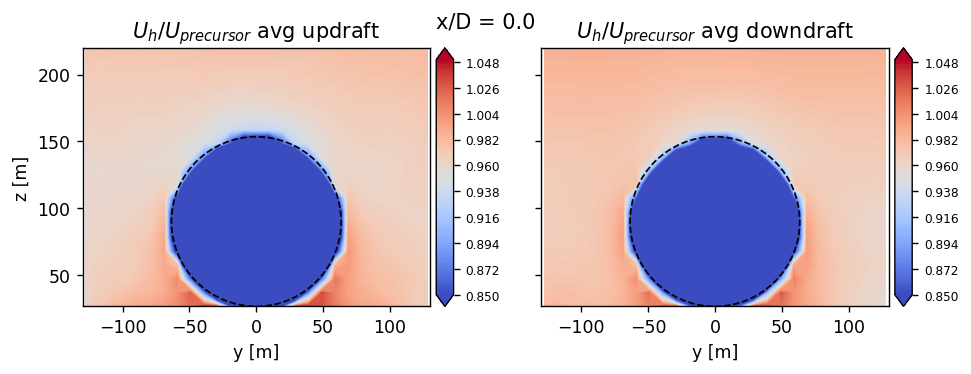

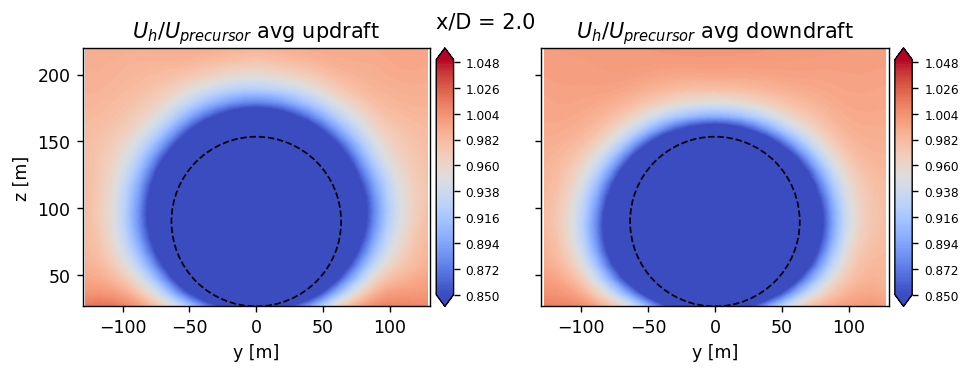

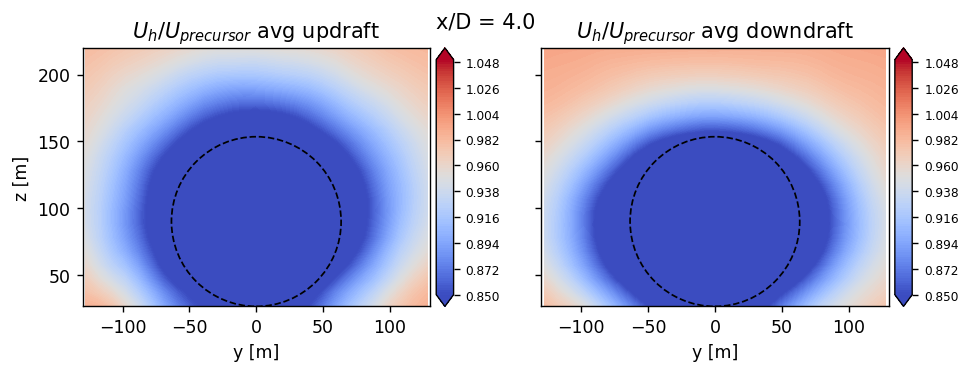

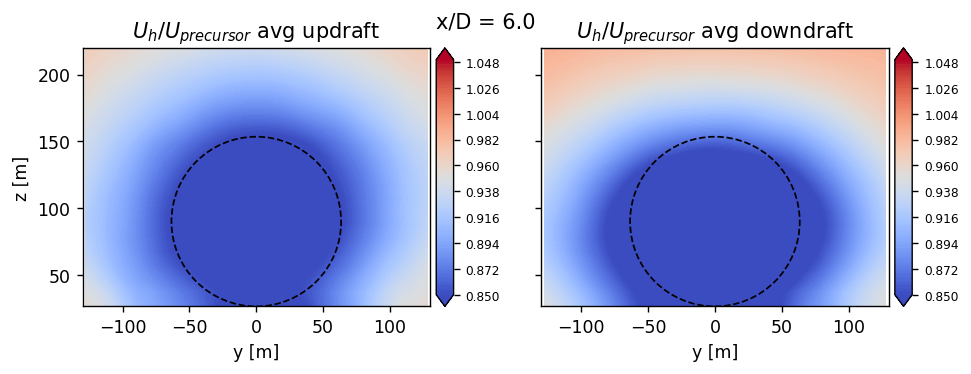

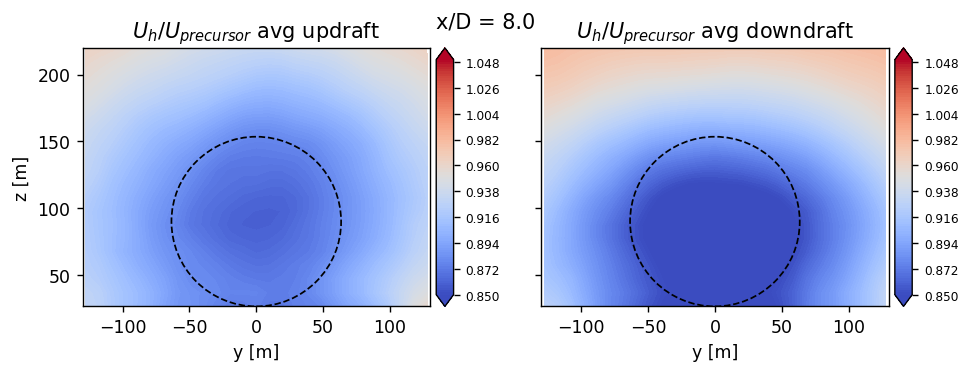

In [21]:
ilevels = [4,5,6,7,8]
fontsize= 8
ulevels = np.linspace(0.85, 1.05, 101)
rotorD  = 127

for i in ilevels:
    fig, axs = plt.subplots(1,2, figsize=(8,3.0), dpi=125, sharey=True)
    circle0 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    circle1 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    
    c0=axs[0].contourf(xm, zm, updraft_wturb_avgVh[i,:,:]/updraft_noturb_avgVh[i,:,:], levels=ulevels, extend='both', cmap='coolwarm')
    c1=axs[1].contourf(xm, zm, dndraft_wturb_avgVh[i,:,:]/dndraft_noturb_avgVh[i,:,:], levels=ulevels, extend='both', cmap='coolwarm')

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c0, ax=axs[0], cax=cax)
    cbar.ax.tick_params(labelsize=fontsize-1)
    axs[0].add_patch(circle0)

    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c1, ax=axs[1], cax=cax)
    cbar.ax.tick_params(labelsize=fontsize-1)
    axs[1].add_patch(circle1)

    for ax in axs:
        ax.set_xlabel('y [m]')
        ax.set_xlim([-130, 130])
        #ax.set_ylim([0, 225])
        ax.set_aspect('equal')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('$U_h/U_{precursor}$ avg updraft')
    axs[1].set_title('$U_h/U_{precursor}$ avg downdraft')
    xlocation=(db1['offsets'][i]-1020)/127.0
    fig.suptitle('x/D = %0.1f'%(xlocation), y=0.925,)
    plt.tight_layout()
    if savefigs:
        plt.savefig(figdir+'/'+'rotorplane_Uh_%0.1f'%xlocation+'.png')
        plt.savefig(figdir+'/'+'rotorplane_Uh_%0.1f'%xlocation+'.svg')
        plt.savefig(figdir+'/'+'rotorplane_Uh_%0.1f'%xlocation+'.pdf')

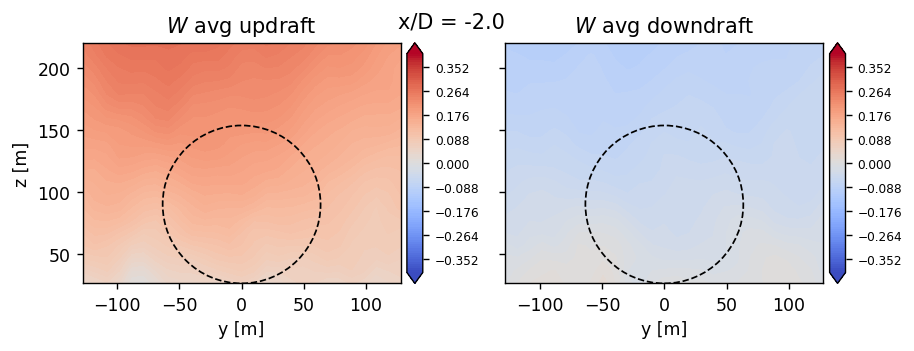

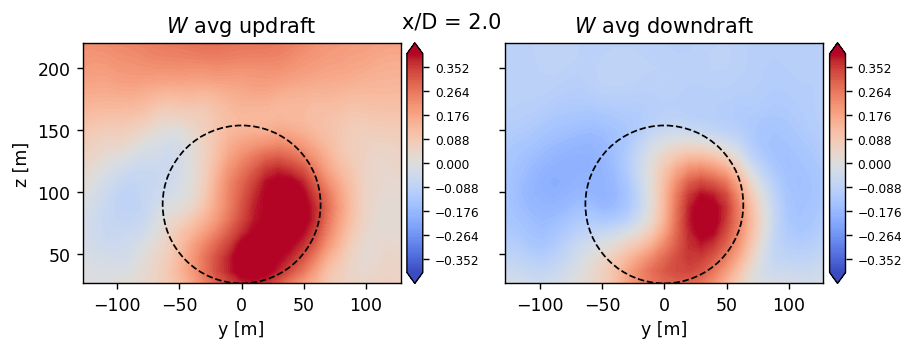

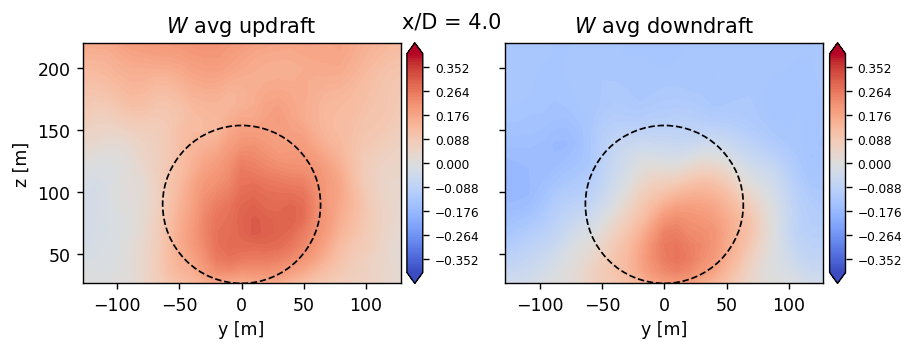

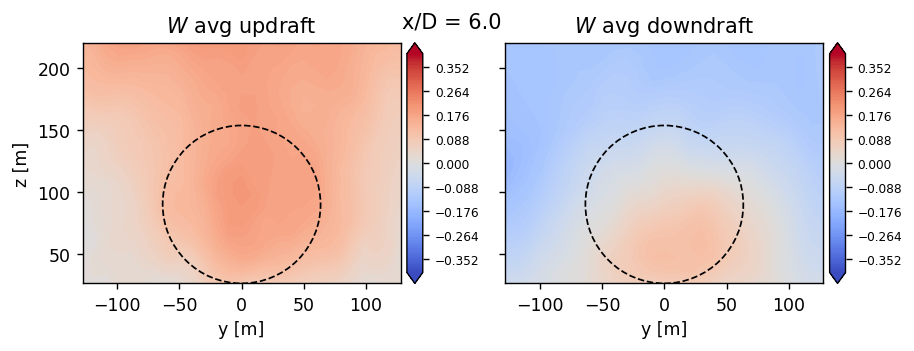

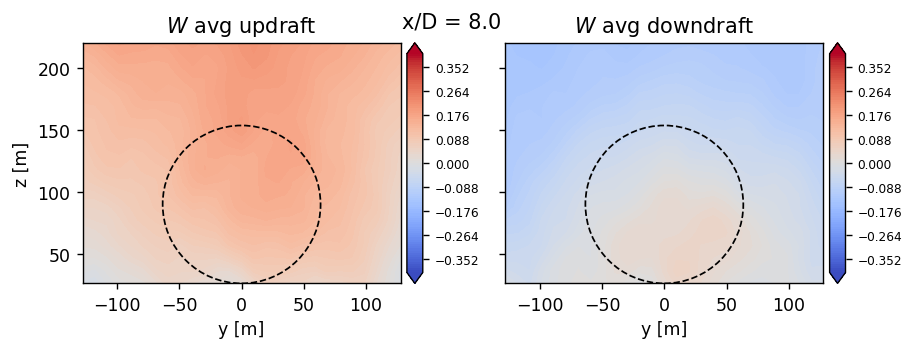

In [14]:
ilevels = [3,5,6,7,8]
fontsize= 8
ulevels = np.linspace(0.85, 1.05, 101)
wlevels = np.linspace(-0.4, 0.4, 101)

rotorD  = 127

for i in ilevels:
    fig, axs = plt.subplots(1,2, figsize=(8,2.5), dpi=125, sharey=True)
    circle0 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    circle1 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    
    c0=axs[0].contourf(xm, zm, updraft_wturb_avgVz[i,:,:], levels=wlevels, extend='both', cmap='coolwarm')
    c1=axs[1].contourf(xm, zm, dndraft_wturb_avgVz[i,:,:], levels=wlevels, extend='both', cmap='coolwarm')

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c0, ax=axs[0], cax=cax)
    cbar.ax.tick_params(labelsize=fontsize-1)
    axs[0].add_patch(circle0)

    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c1, ax=axs[1], cax=cax)
    cbar.ax.tick_params(labelsize=fontsize-1)
    axs[1].add_patch(circle1)

    for ax in axs:
        ax.set_xlabel('y [m]')
        #ax.set_xlim([-200, 200])
        #ax.set_ylim([0, 300])
        ax.set_aspect('equal')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('$W$ avg updraft')
    axs[1].set_title('$W$ avg downdraft')
    fig.suptitle('x/D = %0.1f'%((db1['offsets'][i]-1020)/127.0))